In [1]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

In [2]:
behaviors_path = r'C:\Users\yst\Desktop\MINDsmall_train\behaviors.tsv'
news_path = r'C:\Users\yst\Desktop\MINDsmall_train\news.tsv'

In [3]:
behaviors = pd.read_table(behaviors_path, header=None, names=['impression_id', 'user_id', 'time', 'history', 'impressions'])
news = pd.read_table(news_path, header=None, names=['id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'])

In [4]:
# 建立id到子类字典
id2subcat = {}
for item in news.itertuples():
    id2subcat[item[1]] = str(item[3])

In [5]:
## 数据处理，获取项集
dataset = []
for item in behaviors.itertuples():
    news_id = [] 
    # 添加历史数据进新闻id集合
    if pd.notna(item[4]):
        news_id += item[4].split()
    # 添加曝光新闻
    im = item[5].split()
    for it in im:
        m = it.split('-')
        if m[1] == '1':
            news_id.append(m[0])
    news_category = []
    for id in news_id:
        # 查询新闻信息
        news_category.append(id2subcat[id])
    # 去除项集重复元素
    news_category = list(set(news_category))
    dataset.append(news_category)
print(dataset[0])

['baseball_mlb', 'football_nfl', 'newscrime', 'newspolitics', 'tvnews', 'movienews', 'lifestylebuzz', 'football_ncaa']


In [6]:
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = fpgrowth(df, min_support=0.1, use_colnames=True)
# 输出频繁项集
print(frequent_itemsets)

       support                                      itemsets
0     0.537840                                   (newscrime)
1     0.523148                                (newspolitics)
2     0.514197                               (lifestylebuzz)
3     0.483891                                (football_nfl)
4     0.310420                                      (tvnews)
...        ...                                           ...
2491  0.111057          (lifestylebuzz, lifestyledidyouknow)
2492  0.104807           (tv-celebrity, lifestyledidyouknow)
2493  0.103896              (newsworld, lifestyledidyouknow)
2494  0.101870              (newscrime, lifestyledidyouknow)
2495  0.103724  (lifestylebuzz, lifestyledidyouknow, newsus)

[2496 rows x 2 columns]


In [7]:
# 生成关联规则
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
# 打印频繁项集和关联规则
print("频繁项集:")
print(frequent_itemsets)
print("\n关联规则:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

频繁项集:
       support                                      itemsets
0     0.537840                                   (newscrime)
1     0.523148                                (newspolitics)
2     0.514197                               (lifestylebuzz)
3     0.483891                                (football_nfl)
4     0.310420                                      (tvnews)
...        ...                                           ...
2491  0.111057          (lifestylebuzz, lifestyledidyouknow)
2492  0.104807           (tv-celebrity, lifestyledidyouknow)
2493  0.103896              (newsworld, lifestyledidyouknow)
2494  0.101870              (newscrime, lifestyledidyouknow)
2495  0.103724  (lifestylebuzz, lifestyledidyouknow, newsus)

[2496 rows x 2 columns]

关联规则:
                               antecedents              consequents   support  \
0                              (newscrime)                 (newsus)  0.469111   
1                      (newscrime, newsus)           (tv-celebrity) 

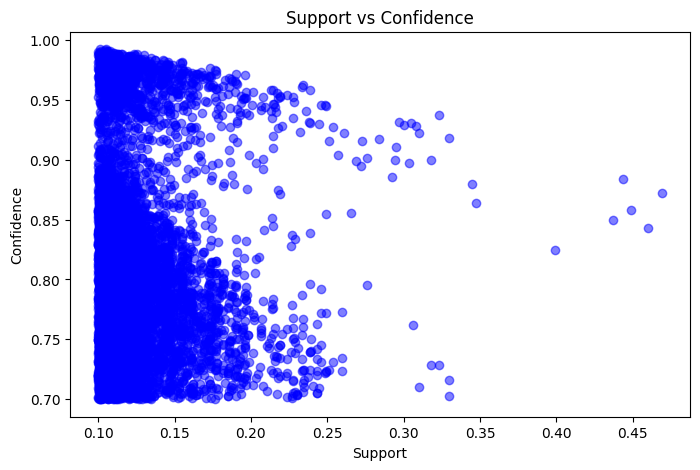

In [8]:
# 散点图展示置信度
plt.figure(figsize=(8, 5))
plt.scatter(rules['support'], rules['confidence'], alpha=0.5, marker="o", color='blue')
plt.title('Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()

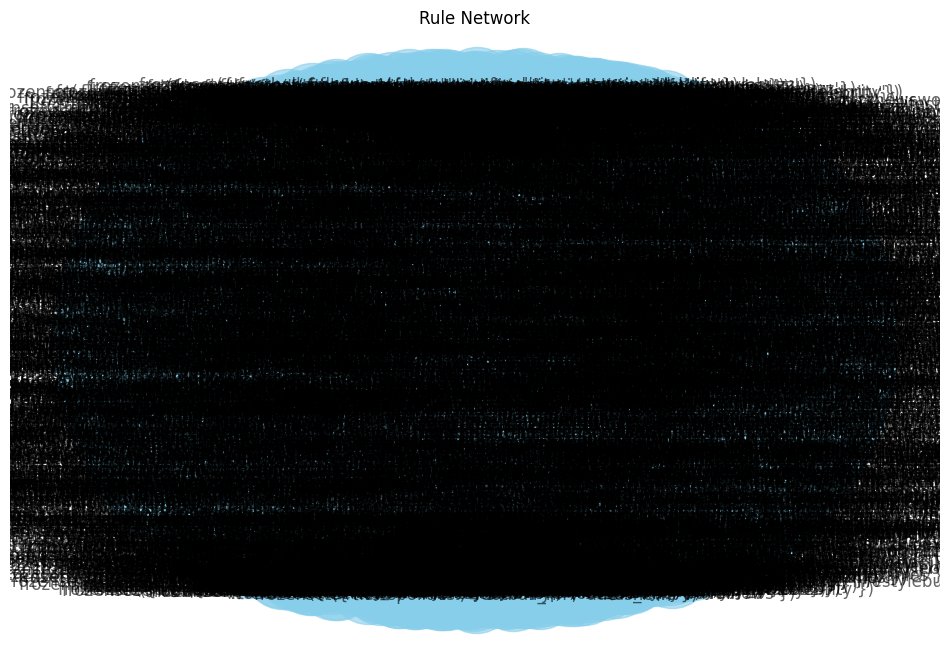

In [9]:
# 网络图：展示规则的前件和后件
fig, ax = plt.subplots(figsize=(12, 8))
GA = nx.DiGraph()

# 添加节点及边
for _, row in rules.iterrows():
    GA.add_edge(str(row['antecedents']), str(row['consequents']), weight=row['confidence'])

pos = nx.spring_layout(GA, k=0.5)  # 布局
nx.draw(GA, pos, with_labels=True, arrows=True, node_color='skyblue', edge_color='k', node_size=3000, alpha=0.6, font_size=12,
        labels={node: node for node in GA.nodes()})
edge_labels = nx.get_edge_attributes(GA, 'weight')
nx.draw_networkx_edge_labels(GA, pos, edge_labels={x: f'{y:.2f}' for x, y in edge_labels.items()})
plt.title('Rule Network')
plt.show()

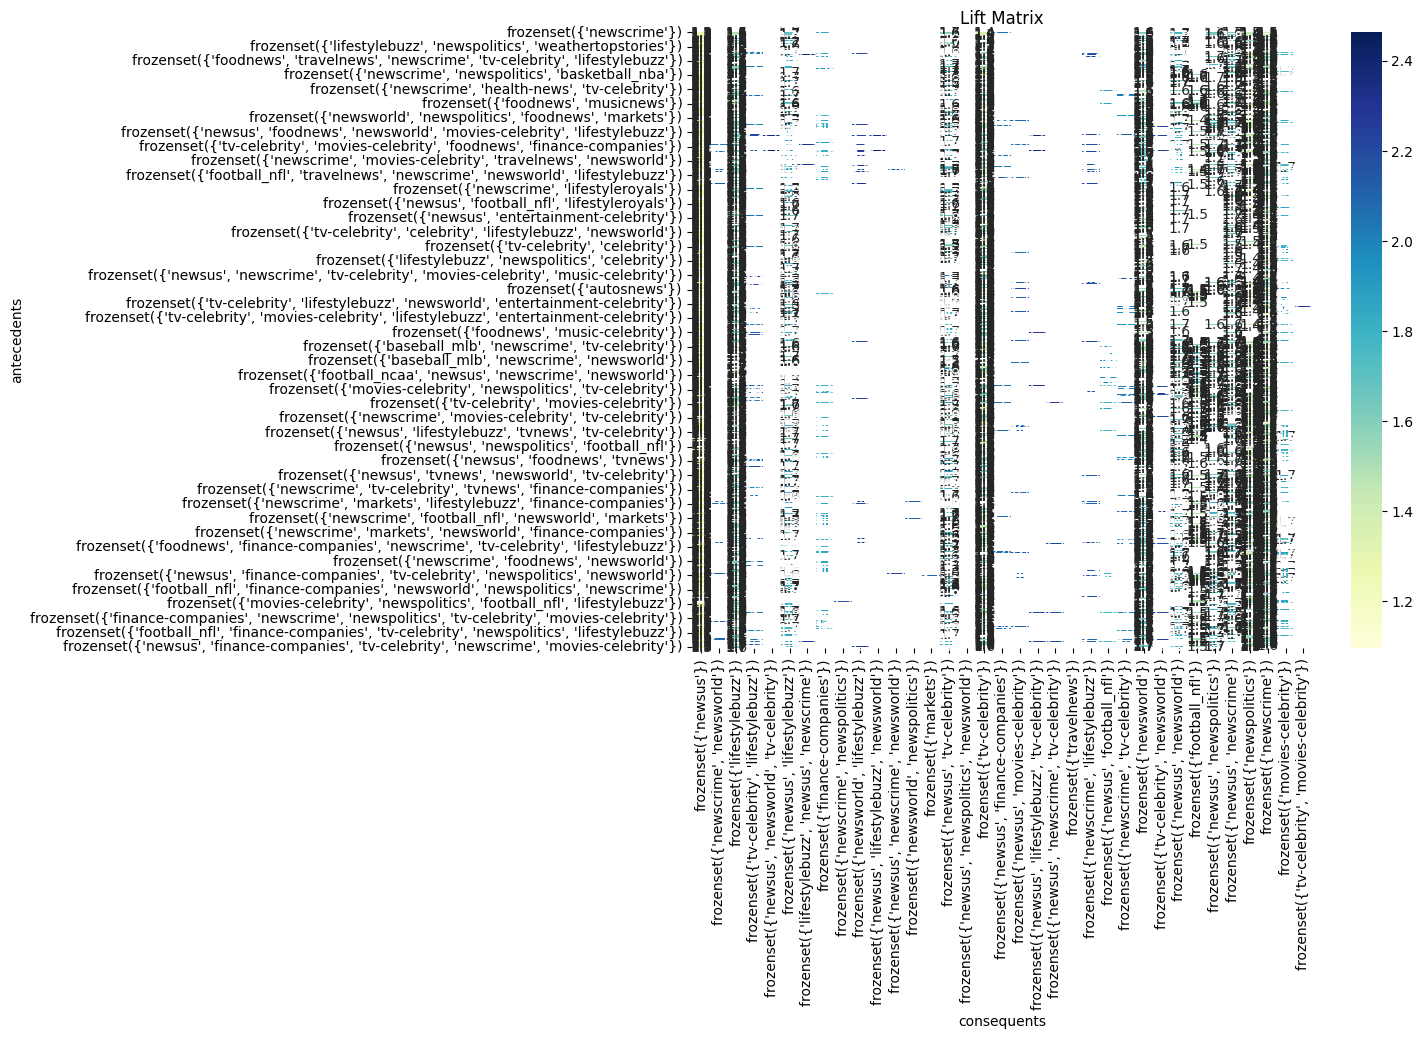

In [10]:
# 数据转换为矩阵形式，用于绘制热图
pivot = rules.pivot(index='antecedents', columns='consequents', values='lift')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, cmap='YlGnBu')
plt.title('Lift Matrix')
plt.show()